# Рисовалка красивых Box-plot

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import math
from statsmodels.stats.multicomp import pairwise_tukeyhsd

Выбор датасета

In [2]:
penguins = sns.load_dataset("penguins")
data = pd.read_csv('C:/Users/KarimovDO/Desktop/базы/гепатит2.csv', sep=';')
group = 'АСТ'
data.head()



,Номер,Группа,АСТ,АЛТ
0,1,K-,253.3,57.1
1,2,K-,280.3,54.2
2,3,K-,290.1,54.7
3,4,K-,292.8,63.3
4,5,K-,298.2,51.4


In [3]:
# Получить виды, отсортированные по алфавиту
species = sorted(data["Группа"].unique())

# y_data — это список длины 3, содержащий значения bill_length_mm для каждого вида.
y_data = [data[data["Группа"] == specie][group].values for specie in species]

# Создать искаженную версию "x" (это только 0, 1 и 2)
# Подробнее об этом в бонус-треке!
jitter = 0.04
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]

Определить цвета и утилиты, которые будут использоваться при построении диаграммы.

In [4]:
# Colors
BG_WHITE = "#fbf9f4"
# ffffff делый
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"

# Colors taken from Dark2 palette in RColorBrewer R library
COLOR_SCALE = ["#9e1b1b", "#1b9e22", "#1b9a9e", "#241b9e", "#9e1b97",]

# Горизонтальные позиции для скрипки.
# Это произвольные числа. Например, они могли быть [-1, 0, 1].
POSITIONS = [0, 1, 2, 3, 4]

# Horizontal lines надо потом вычислит формулой


HLINES = [(math.floor(data[group].min()/10))*10 - 10 , 
          math.floor(((math.floor(data[group].min()/10))*10 + (math.ceil(data[group].max()/10))*10)/2), 
          (math.ceil(data[group].max()/10))*10 + 10]

 F-Anova 7.881, p = 0.0003
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1   group2  meandiff p-adj    lower    upper   reject
-----------------------------------------------------------
      K+       K-  83.9333 0.0007   28.4475 139.4192   True
      K+   Гептор  46.5583 0.1401   -8.9275 102.0442  False
      K+ Мексидол   25.825 0.6846  -29.6609  81.3109  False
      K+      ОМУ  30.0667  0.549  -25.4192  85.5525  False
      K-   Гептор  -37.375 0.3297  -92.8609  18.1109  False
      K- Мексидол -58.1083 0.0358 -113.5942  -2.6225   True
      K-      ОМУ -53.8667 0.0611 -109.3525   1.6192  False
  Гептор Мексидол -20.7333 0.8289  -76.2192  34.7525  False
  Гептор      ОМУ -16.4917 0.9175  -71.9775  38.9942  False
Мексидол      ОМУ   4.2417 0.9995  -51.2442  59.7275  False
-----------------------------------------------------------


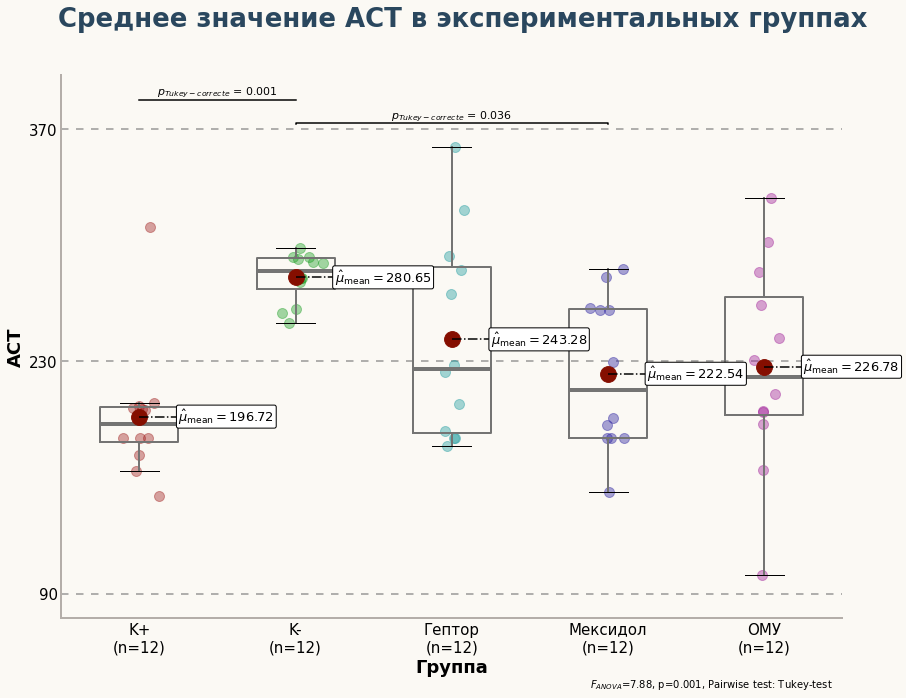

In [5]:
fig, ax = plt.subplots(figsize= (14, 10))

# Немного макета -------------------------------------------------------------
# Фоновый цвет
fig.patch.set_facecolor(BG_WHITE)
ax.set_facecolor(BG_WHITE)

# # Горизонтальные линии, которые используются в качестве ориентира шкалы
for h in HLINES:
    ax.axhline(h, color=GREY50, ls=(0, (5, 5)), alpha=0.8, zorder=0)

# Добавляем скрипки -------------------------------------------------------------- -----
# bw_method="silverman" означает пропускную способность плотности ядра
# оценка вычисляется по эмпирическому правилу Сильвермана.
# Подробнее об этом в бонус-треке ;)

# Вывод сохраняется в 'скрипках', используемых для настройки их внешнего вида
#violins = ax.violinplot(
#    y_data, 
#    positions=POSITIONS,
#    widths=0.45,
#    bw_method="silverman",
#    showmeans=False, 
#    showmedians=False,
#    showextrema=False
#)

# Настроить скрипки (удалить заливку, настроить линию и т. д.)
#for pc in violins["bodies"]:
#    pc.set_facecolor("none")
#    pc.set_edgecolor(BLACK)
#    pc.set_linewidth(1.4)
#    pc.set_alpha(1)
    

# Добавление диаграмм -------------------------------------------------------------- ----
# Обратите внимание, что свойства медианы и прямоугольника передаются
# как словари.

medianprops = dict(
    linewidth=4, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_DARK
)

ax.boxplot(
    y_data,
    positions=POSITIONS, 
    showfliers = False, # Do not show the outliers beyond the caps.
#    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots ----------------------------------------------
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s = 100, color=color, alpha=0.4)
    
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = st.f_oneway(data[data['Группа'] == species[0]][group], 
                             data[data['Группа'] == species[1]][group],
                             data[data['Группа'] == species[2]][group], 
                             data[data['Группа'] == species[3]][group])

# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=data[group], groups=data['Группа'], alpha=0.05)

#Добавить метки среднего значения
means = [y.mean() for y in y_data]
for i, mean in enumerate(means):
    # Добавить точку, представляющую среднее значение
    ax.scatter(i, mean, s=250, color=RED_DARK, zorder=3)
    
    # Добавляем строку, соединяющую среднее значение и его метку
    ax.plot([i, i + 0.25], [mean, mean], ls="dashdot", color="black", zorder=3)
    
    # Добавить метку среднего значения.
    ax.text(
        i + 0.25,
        mean,
        r"$\hat{\mu}_{\rm{mean}} = $" + str(round(mean, 2)),
        fontsize=13,
        va="center",
        bbox = dict(
            facecolor="white",
            edgecolor="black",
            boxstyle="round",
            pad=0.15
        ),
        zorder=10 # чтобы убедиться, что строка находится сверху
    )

# Добавить несколько сравнений p-значение для средней разницы -----------
# Линии графика, указывающие, какие средства сравниваются
# 'tick_len' задает длину галочки в конце каждой строки
# дучше прибавлять по 4%


po = data[group].max()

p = po + po * 0.04
tick_len = 0.25
pad = 0.2

#полоски со значимостью порядок полос 7 4 5 9 0 8 1 6 2 3  

if m_comp.pvalues[7] <= 0.05:
    ax.plot([2, 2, 3, 3], [p- tick_len, p,p,p- tick_len], c="black")
    label = f"$p_{{Tukey-correcte}}$ = {round(m_comp.pvalues[7], 3)}"
    ax.text(2.5, p + pad, label, fontsize=11, va="bottom", ha="center")
    p += po * 0.04

if m_comp.pvalues[4] <= 0.05:
    ax.plot([1, 1, 2, 2], [p- tick_len, p,p,p- tick_len], c="black")
    label = f"$p_{{Tukey-correcte}}$ = {round(m_comp.pvalues[4], 3)}"
    ax.text(1.5, p + pad, label, fontsize=11, va="bottom", ha="center")
    p += po * 0.04
    
if m_comp.pvalues[5] <= 0.05:
    ax.plot([1, 1, 3, 3], [p- tick_len, p,p,p- tick_len], c="black")
    label = f"$p_{{Tukey-correcte}}$ = {round(m_comp.pvalues[5], 3)}"
    ax.text(2, p + pad, label, fontsize=11, va="bottom", ha="center")
    p += po * 0.04

if m_comp.pvalues[9] <= 0.05:
    ax.plot([3, 3, 4, 4], [p- tick_len, p,p,p- tick_len], c="black")
    label = f"$p_{{Tukey-correcte}}$ = {round(m_comp.pvalues[9], 3)}"
    ax.text(3.5, p + pad, label, fontsize=11, va="bottom", ha="center")
    p += po * 0.04
    
if m_comp.pvalues[0] <= 0.05:
    ax.plot([0, 0, 1, 1], [p- tick_len, p,p,p- tick_len], c="black")
    label = f"$p_{{Tukey-correcte}}$ = {round(m_comp.pvalues[0], 3)}"
    ax.text(0.5, p + pad, label, fontsize=11, va="bottom", ha="center")
    p += po * 0.04

if m_comp.pvalues[8] <= 0.05:
    ax.plot([2, 2, 4, 4], [p- tick_len, p,p,p- tick_len], c="black")
    label = f"$p_{{Tukey-correcte}}$ = {round(m_comp.pvalues[8], 3)}"
    ax.text(3, p + pad, label, fontsize=11, va="bottom", ha="center")
    p += po * 0.04

if m_comp.pvalues[1] <= 0.05:
    ax.plot([0, 0, 2, 2], [p- tick_len, p,p,p- tick_len], c="black")
    label = f"$p_{{Tukey-correcte}}$ = {round(m_comp.pvalues[1], 3)}"
    ax.text(1, p + pad, label, fontsize=11, va="bottom", ha="center")
    p += po * 0.04

if m_comp.pvalues[6] <= 0.05:
    ax.plot([1, 1, 4, 4], [p- tick_len, p,p,p- tick_len], c="black")
    label = f"$p_{{Tukey-correcte}}$ = {round(m_comp.pvalues[6], 3)}"
    ax.text(2.5, p + pad, label, fontsize=11, va="bottom", ha="center")
    p += po * 0.04

if m_comp.pvalues[2] <= 0.05:
    ax.plot([0, 0, 3, 3], [p- tick_len, p,p,p- tick_len], c="black")
    label = f"$p_{{Tukey-correcte}}$ = {round(m_comp.pvalues[2], 3)}"
    ax.text(1.5, p + pad, label, fontsize=11, va="bottom", ha="center")
    p += po * 0.04

if m_comp.pvalues[3] <= 0.05:
    ax.plot([0, 0, 4, 4], [p- tick_len, p,p,p- tick_len], c="black")
    label = f"$p_{{Tukey-correcte}}$ = {round(m_comp.pvalues[3], 3)}"
    ax.text(2, p + pad, label, fontsize=11, va="bottom", ha="center")
    p += po * 0.04

# Настройка макета --------------------------------------------------------------
# Скрыть шипы
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# Настроить цвет шипов
ax.spines["left"].set_color(GREY_LIGHT)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_color(GREY_LIGHT)
ax.spines["bottom"].set_linewidth(2)

# Настройка меток и галочек
ax.tick_params(length=0)
ax.set_yticks(HLINES)
ax.set_yticklabels(HLINES, size=15)
ax.set_ylabel(group, size=18, weight="bold")

# xlabels учитывает размер выборки для каждого вида
xlabels = [f"{specie}\n(n={y_data[i].size})" for i, specie in enumerate(species)]
ax.set_xticks(POSITIONS)
ax.set_xticklabels(xlabels, size=15, ha="center", ma="center")
ax.set_xlabel("Группа", size=18, weight="bold")

# Рисунок используется для заголовка, а ось — для подзаголовка.
# Заголовок
stats = [
    r"$\log_{\rm{e}}(\rm{BF}_{01})=-195.59$",
    r"$\widehat{R^2}_{\rm{Bayesian}}^{\rm{posterior}}=0.70$",
    r"$\rm{CI}_{95\%}^{\rm{HDI}}[0.67, 0.73]$",
    r"$r^{\rm{Cauchy}}_{\rm{JZS}} = 0.71$",
]

fig.suptitle(
    f"Среднее значение {group} в экспериментальных группах",
    x = 0.122,
    y = 0.975,
    ha="left",
    fontsize=26,
#    fontname="Lobster Two",
    color=BLUE,
    weight="bold",    
)

# # Подзаголовок
  
stats = [
    f"$F_{{ANOVA}}$={round(fvalue,2)}",
    f"p={round(pvalue,3)+0.001}",
    f"Pairwise test: Tukey-test"
]


#ax.set_title(
#    ", ".join(stats),
#    loc="left",
#    ha="left",
#    fontsize=20,
#    color=BLUE_DARK
#)

# Примечания внизу справа
fig.text(
    0.65,
    0.03,
    ", ".join(stats),
    fontsize=10
)

fig

print(f' F-Anova {round(fvalue, 2)}, p = {round(pvalue, 4)}')
print(m_comp)